# Implementing `CutMix` with `Fastai`
> In this blog post we will first checkout what `CutMix` is and then try and implement it using `Fastai2`. Also create a PR if we are successful. 

## So what is `CutMix`?

From the [research paper](https://arxiv.org/pdf/1905.04899.pdf), `CutMix` is a way to combine two images. It comes from `MixUp` and `Cutout`. In this data augmentation technique:
> patches are cut and pasted among training images where the ground truth labels are also mixed proportionally to the area of the patches

Also, from the paper: 
> By making efficient use of training pixels and retaining the regularization effect of regional dropout, CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly-supervised localization task. Moreover, unlike previous augmentation methods, our CutMix-trained ImageNet classifier, when used as a pretrained model, results in consistent performance gains in Pascal detection and MS-COCO image captioning benchmarks. We also show that CutMix improves the model robustness against input corruptions and its out-of-distribution detection performances. 

The authors of the research paper were kind enough to make the source code available at [this repository](https://github.com/clovaai/CutMix-PyTorch).

The formula for CutMix from the research paper is given as: 

![](./CutMix.png?raw=true)

Where, `M` is a binary mask indicating where to drop out and fill in from two images. The combination ratio `lambda` is similar to Mixup and follows a Beta distribution. 

## What is `Beta` distribution? 

Let's see it in code: 

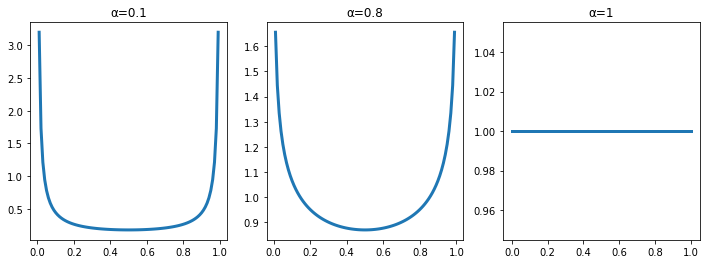

In [1]:
%matplotlib inline 

from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 100)

_,axs = plt.subplots(1,3, figsize=(12,4))
for α,ax in zip([0.1,0.8, 1], axs):
    y = beta.pdf(x, α, α)
    ax.plot(x, y, linewidth=3);
    ax.set_title(f"α={α}")

From the probability charts above for Beta distribution, we can see that for a lower value of α, we pick values close to 0 or 1. This picked up value is called `lambda` and refers to the amount of mixup between two images.

For an excellent resource on what is `Mixup` refer to this notebook [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/10b_mixup_label_smoothing.ipynb). I would highly recommend reading this before moving forward.

For CutMix, `lambda` refers to the combination ratio between two data points. In the the case of `CutMix` the authors decided to set alpha to 1, that is λ is sampled from uniform distribution (0,1).

From the paper, the box coordinates are defined as:

![](./rwrh.png?raw=true)

The most important part for us the Appendix A inside the paper, which has details regarding the code-level implementation.

![](./psuedo_code_cutmix.png?raw=true)

# Training `MixUp`

In [2]:
from fastai2.vision.all import *
from torch.distributions.beta import Beta

In [3]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, 
                                           Categorize()]], 
               splits=GrandparentSplitter()(items))
dls = tds.dataloaders(after_item=[ToTensor(), IntToFloatTensor()])
mixup = MixUp(0.5)
learn = cnn_learner(dls, resnet34, metrics=[accuracy])

In [4]:
# learn.fine_tune(5)

# Training `CutMix`

In [5]:
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def begin_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def begin_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/(W*H)).type(torch.float)
        
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))
    
    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [6]:
path = untar_data(URLs.PETS)

pre_sz     = 256
sz         = 224
bs         = 64
pat        = r'([^/]+)_\d+.*$'
fnames     = get_image_files(path/'images')

item_tfms  = [Resize(pre_sz, method='crop')]
batch_tfms = [*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)]
dls = ImageDataLoaders.from_name_re(path, fnames, pat, 
                                    bs=bs, item_tfms=item_tfms, 
                                    batch_tfms=batch_tfms)

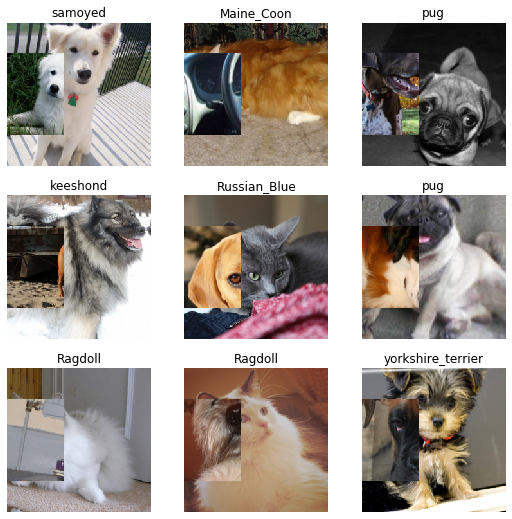

In [7]:
cutmix = CutMix(alpha=1.)
learn = Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix)
learn._do_begin_fit(1)
learn.epoch,learn.training = 0,True
learn.dl = dls.train
b = dls.one_batch()
learn._split(b)
learn('begin_batch')
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

In [8]:
learn = cnn_learner(dls, resnet50, loss_func=CrossEntropyLossFlat(), cbs=cutmix, metrics=[accuracy, error_rate])

In [9]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.203677,0.325289,0.895129,0.104871,00:51
1,1.428585,0.304932,0.900541,0.099459,00:49
2,1.249418,0.278341,0.897835,0.102165,00:49
3,0.895618,0.227070,0.924222,0.075778,00:49
4,0.943740,0.225676,0.925575,0.074425,00:49


In [10]:
learn.save('stage-1-50')

In [11]:
learn.load('stage-1-50')

In [12]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.802029,0.222298,0.927605,0.072395,01:08
1,0.659983,0.203077,0.930311,0.069689,01:07
2,0.777232,0.203848,0.930311,0.069689,01:07


In [13]:
learn.save('stage-2-50')